In [14]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))  
from tools.dictionary import *
from math import log10

import pandas as pd
db1 = pd.read_feather('data/financial_reports_upto_2023-10-06_part1.feather')
code = '373220'
code = '005930'
# code_list = db1['code'].unique().tolist()+db2['code'].unique().tolist()+db3['code'].unique().tolist()


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

quarter_cols= [s for s in db1.columns.values if 'Q' in s]
y = db1.loc[(db1['code']==code) & (db1['fs_div']=='CFS'), ['account']+quarter_cols].set_index(['account'])
y.columns = [s.replace('2020','XX').replace('20','').replace('XX','20').replace('_','.') for s in quarter_cols]
yiu = y/KRW_UNIT # y in KRW_UNIT
display(yiu)

,15.1Q,15.2Q,15.3Q,15.4Q,16.1Q,16.2Q,16.3Q,16.4Q,17.1Q,17.2Q,...,21.1Q,21.2Q,21.3Q,21.4Q,22.1Q,22.2Q,22.3Q,22.4Q,23.1Q,23.2Q
account,,,,,,,,,,,,,,,,,,,,,
liquid_assets,<NA>,<NA>,<NA>,1248147.25,1265871.69,1301630.49,1321667.69,1414297.04,1292842.04,1321726.81,...,2091553.53,1911185.24,2127930.19,2181631.85,2323690.82,2362874.91,2508806.37,2184705.81,2144421.41,2039753.73
illiquid_assets,<NA>,<NA>,<NA>,1173647.96,1146526.2,1137976.24,1123046.87,1207446.2,1349331.68,1454167.55,...,1836709.21,1936591.45,1976276.99,2084579.73,2069578.77,2117531.59,2193977.72,2299539.26,2396496.36,2440251.79
assets,<NA>,<NA>,<NA>,2421795.21,2412397.89,2439606.73,2444714.56,2621743.24,2642173.72,2775894.36,...,3928262.74,3847776.69,4104207.18,4266211.58,4393269.59,4480406.5,4702784.09,4484245.07,4540917.77,4480005.52
liquid_debts,<NA>,<NA>,<NA>,505029.09,490495.0,480081.64,504594.81,547040.95,568431.32,584684.31,...,901094.62,724614.51,818719.64,881171.33,904637.01,833622.68,852856.69,783448.52,760574.48,707806.38
illiquid_debts,<NA>,<NA>,<NA>,126168.07,138641.03,141099.93,144755.96,145071.96,175562.85,184152.57,...,284482.21,299919.52,317826.36,336040.94,335723.39,367717.18,400858.51,153300.51,182349.13,182442.88
debts,<NA>,<NA>,<NA>,631197.16,629136.03,621181.57,649350.77,692112.91,743994.17,768836.88,...,1185576.83,1024534.03,1136546.0,1217212.27,1240360.4,1201339.86,1253715.2,936749.03,942923.61,890249.26
capital_stock,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,8975.14,8975.14,8975.14,8975.14,8975.14,8975.14,8975.14,8975.14,8975.14,8975.14
retained_earnings,<NA>,<NA>,<NA>,1851320.14,1832186.14,1859204.88,1861691.37,1930863.17,1967244.97,1992239.59,...,2660661.42,2750851.85,2848269.92,2930647.63,3017431.52,3102167.85,3168902.72,3379464.07,3368818.52,3383106.55
equity,<NA>,<NA>,<NA>,1790598.05,1783261.86,1818425.16,1795363.79,1929630.33,1898179.55,2007057.48,...,2742685.91,2823242.66,2967661.18,3048999.31,3152909.19,3279066.64,3449068.89,3547496.04,3597994.16,3589756.26


Text(0.5, 0.98, 'Consolidated Financial Statement Summary - company: 005930')

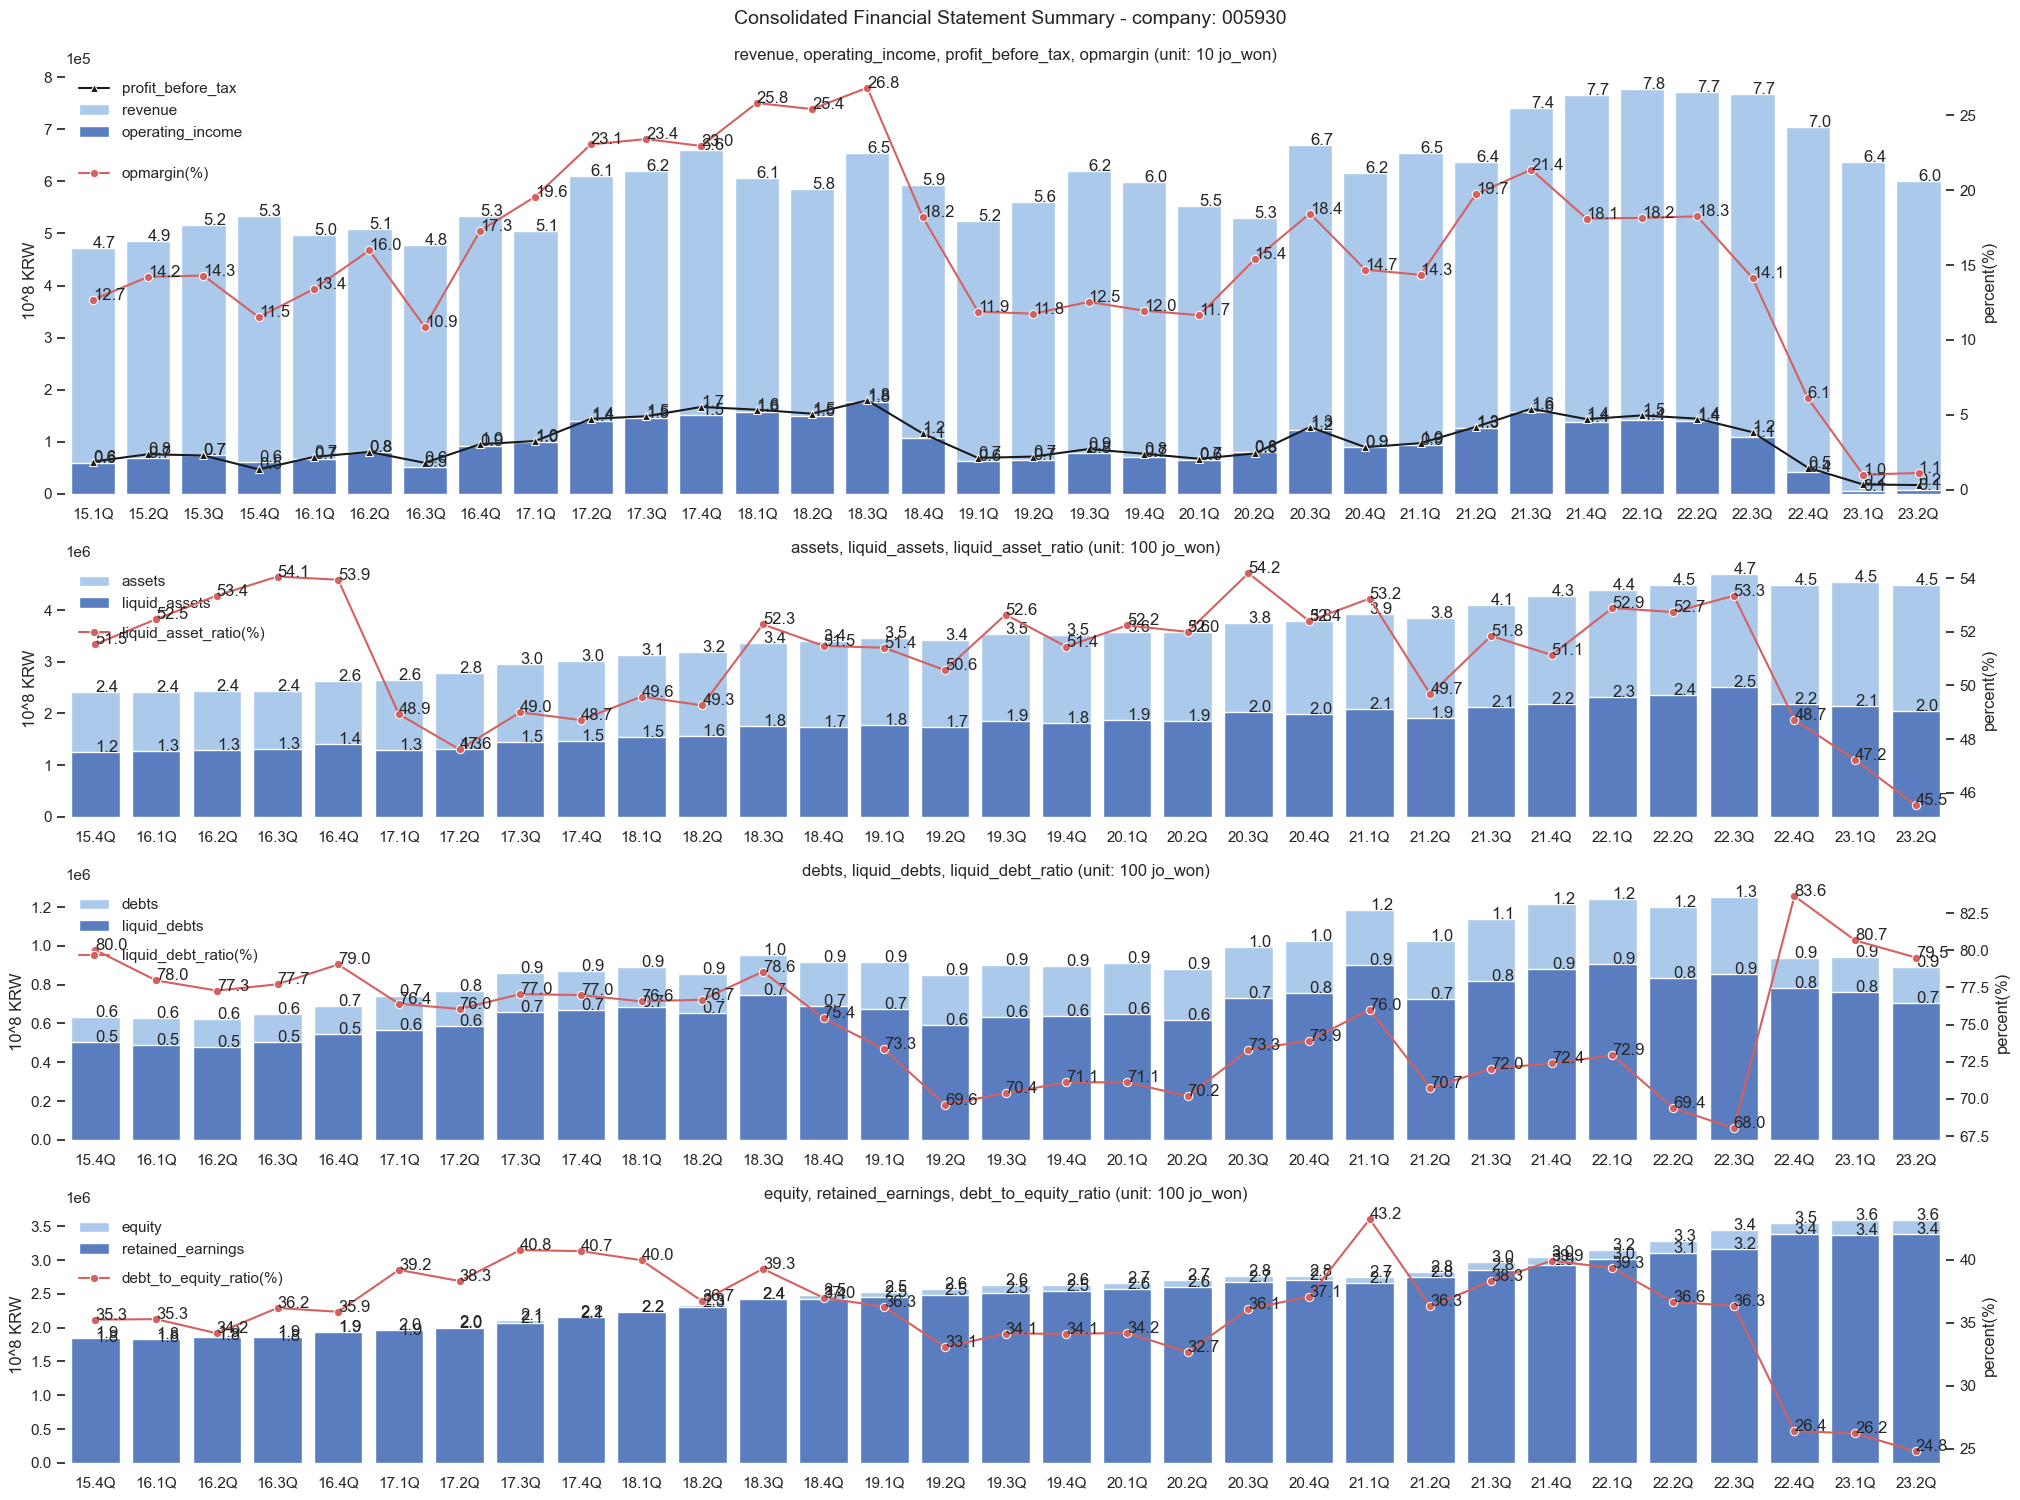

In [16]:
f, ax = plt.subplots(4, 1, figsize=(20, 15), constrained_layout=True, gridspec_kw={'height_ratios': [5, 3, 3, 3]})
f.set_constrained_layout_pads(w_pad=0, h_pad=0.1, hspace=0, wspace=0.)
axr = [s.twinx() for s in ax]
sns.set_theme(style="white")
sns.despine(left=True, bottom=True)

def plot_barline(axno, data, y1, y2, y3, y4=None, krw_unit='10^8 KRW'):
    if y4 != None:
        tx = data.loc[y1].isnull()*data.loc[y2].isnull().values*data.loc[y4].isnull().values
    else: 
        tx = data.loc[y1].isnull()*data.loc[y2].isnull().values
    x = [s for s in data.columns.values if not tx[s]]

    sns.set_color_codes("pastel")
    sns.barplot(x=x, y=data.loc[y1, x], ax = ax[axno], label=y1, color="b")
    ax[axno].ticklabel_format(axis='y', scilimits=[-3, 3])
    t_ = ax[axno].get_yticklabels()[-1].get_position()[1] / float(ax[axno].get_yticklabels()[-1].get_text())

    unit_list = ['uk_won','10 uk_won','100 uk_won','1,000 uk_won', 'jo_won', '10 jo_won', '100 jo_won']
    unit_exp = unit_list[int(log10(t_))]

    for index, value in enumerate(data.loc[y1, x]):
        try:
            v = str(round(value/t_, 1))
            ax[axno].text(index, value, v)
        except: 
            pass

    sns.set_color_codes("muted")
    sns.barplot(x=x, y=data.loc[y2, x], ax = ax[axno], label=y2, color="b")
    for index, value in enumerate(data.loc[y2, x]):
        try:
            v = str(round(value/t_, 1))
            ax[axno].text(index, value, v)
        except: 
            pass

    if y4 != None:
        sns.lineplot(x=x, y=data.loc[y4, x], ax = ax[axno], label=y4, color="k", marker='^')
        for index, value in enumerate(data.loc[y4, x]):
            try:
                v = str(round(value/t_, 1))
                ax[axno].text(index, value, v)
            except: 
                pass

    ax[axno].legend(ncol=1, loc="upper left", frameon=False)
    ax[axno].set(ylabel=krw_unit)
    if y4 != None:
        ax[axno].set_title(y1+', '+y2+', '+y4+', '+y3+' (unit: '+unit_exp+')')
    else: 
        ax[axno].set_title(y1+', '+y2+', '+y3+' (unit: '+unit_exp+')')

    sns.lineplot(x=x, y=data.loc[y3, x], ax = axr[axno], label=y3+'(%)', color="r", marker='o')
    for index, value in enumerate(data.loc[y3, x]):
        try:
            v = str(round(value, 1))
            axr[axno].text(index, value, v)
        except: 
            pass

    axr[axno].legend(ncol=1, loc="upper left", frameon=False, bbox_to_anchor=(0, 0.8))
    axr[axno].set(ylabel="percent(%)")

    ax[axno].set_xlim(-0.5, len(x) - 0.5)
    axr[axno].set_xlim(-0.5, len(x) - 0.5)

yiu.loc['opmargin', :] = yiu.loc['operating_income']/yiu.loc['revenue']*100
yiu.loc['liquid_asset_ratio', :] = yiu.loc['liquid_assets']/yiu.loc['assets']*100
yiu.loc['liquid_debt_ratio', :] = yiu.loc['liquid_debts']/yiu.loc['debts']*100
yiu.loc['debt_to_equity_ratio', :] = yiu.loc['debts']/yiu.loc['equity']*100

plot_barline(0, yiu, 'revenue', 'operating_income', 'opmargin', 'profit_before_tax')
plot_barline(1, yiu, 'assets', 'liquid_assets', 'liquid_asset_ratio')
plot_barline(2, yiu, 'debts', 'liquid_debts', 'liquid_debt_ratio')
plot_barline(3, yiu, 'equity', 'retained_earnings', 'debt_to_equity_ratio')

f.suptitle('Consolidated Financial Statement Summary - company: '+code, fontsize=14)


In [ ]:
# organize the above into a function
# make a company report 
# search by code
# publish it to a webpage
# company info update function
# grouping... comparison by industry... 
# include private companies